# Transfer Learning for Classification

**Please save a copy of the notebook in your local drive! Otherwise you will lose your progress.**

## Introduction & a Bit of History

Over the course of CS189, you have trained machine learning models for specific applications, whether it is classification or regression. Although this has been effective, modern machine learning researchers use a considerably different pipeline for training models.

What people have been doing instead is to train a massive model for a very broad objective, and then finetune the model on a smaller dataset. This approach has given us a lot of great-performing models and agents, the most notable being that of [GPT](https://arxiv.org/abs/2005.14165) models (there are also more models that does the same job, BERT, DINO, masked autoencoders are the ones that immediately came to mind, but unfortunately there are no equivalent in robotics), as they relied on internet scale pretraining (with GPT specifically, people use what's called next-token prediction as the objective). You don't need to know exactly how this works in this class, but this is drastically different than what we have done by fitting a model to exactly one dataset.

Of course, we do not have the computational resources to retrain any GPT3+ models, but we can try a smaller problem with transfer learning! Here is a little story behind the origin of transfer learning:

Back in 2013, neural-net based image recognition methods such as AlexNet has already swept through the ML community by storm, and people are trying to tackle the next problem in computer vision, which is object segmentation (using bounding boxes). The problem is that the corresponding dataset, [Pascal-VOC](https://paperswithcode.com/dataset/pascal-voc), is very small for neural networks (only 1500 training images and 20,000 data entries).

So what did people do? Researchers have found out is that instead of training a neural network from scratch, using weights from networks trained on [ImageNet classification](https://paperswithcode.com/sota/image-classification-on-imagenet) as the starting point actually helped to achieve very good tracking accuracy on these tasks (if you are so inclined, feel free to read [R-CNN](https://arxiv.org/pdf/1311.2524) to see what they have done)! In fact, this method worked so well that it not only inspired the idea of "pretraining" across the machine learning community, but also sparked a [funny bet](https://people.eecs.berkeley.edu/~efros/gelato_bet.html) between two UC Berkeley professors.

In previous semesters, we actually didn't want you to do transfer learning for CIFAR-10, but with how much the machine learning world has changed, we are changing the focus specifically on transfer learning to get you more familiar with these paradigms and hope you can have successes working with these large models!

## Transfer Learning for CIFAR-10

In this question, we will explore how to effectively use transfer learning to learn a new task with a *pretrained* network. In essence, the idea of pretraining is that a network has been trained on another objective, and that the weights are something more desirable than random initialization. Transfer learning takes advantage of that and aims to make training faster compared to that of training from scratch.

In [1]:
# utils for data loading
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

import time
import numpy as np
import pandas as pd

import os
import time

import random
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
seed = 42  # Define the seed value
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

First, let's start with making the necessary transformations of our training data. CIFAR-10 is a collection of 60,000 32x32x3 images divided into 10 classes. If you want more information, please refer to [this link](https://www.cs.toronto.edu/~kriz/cifar.html) by Alex Krizhevsky et al.

However, most of the models readily available are trained on ImageNet, which is 224x224x3. Although one can hack the weights of a neural network and design a new network on top of it, it is much easier to simply scale up the images by a factor of 7 (224/32) and feed the network the magnified images. Let's do that instead!

In [4]:
## transforms to match that of the transforms in ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (ImageNet size)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

## download training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 transform=transform, download=True)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                 transform=transform, download=True)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Let's also visualize some images within CIFAR-10 Dataset!

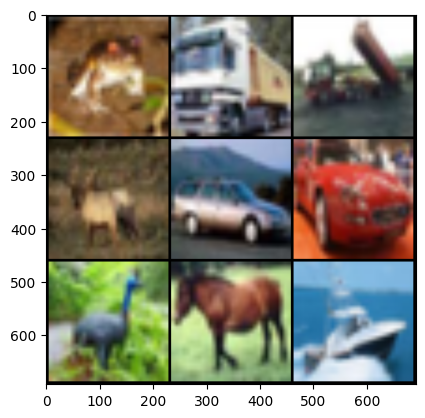

In [5]:
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
])

viz_dataset = datasets.CIFAR10(root='./data', train=True,
                                 transform=viz_transform, download=True)

images = [viz_dataset[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

Now go to *torchvision.models* module, and pick one of the following models that you would like.

- VGG Networks (all VGG networks are fine)

- AlexNet

- ResNet-18, -34, or -50

A more expressive model, such as using vision transformers, will not be allowed (they also have hundreds of millions of parameters, which is not friendly for your colab compute units). All model weights must directly come from *torchvision.models* module.

In order to perform transfer learning, you should do the following steps:

1. Load a pretrained network on another dataset.
2. Freeze most of the layers of the pretrained network and discard a part of the network not relevant to your model.
3. Append a new MLP at the end of the network, and allow gradients to pass through the new MLP (and other non-frozen parts of the network).
4. Train the new network.

**Although we would like you to explore transfer learning, here are some rules you must follow:**

1. You may not change the model architecture other than the final linear layers.
2. You must freeze all of the weights in the convolutional layers.
3. You may not have more than 3 million trainable parameters.

In [6]:
class TransferCIFAR10(nn.Module):
  def __init__(self, num_classes=10):
    super(TransferCIFAR10, self).__init__()

    # Load model
    resnet18 = models.resnet18(pretrained=True) # Load pretrained weights
    for param in resnet18.parameters():
      param.requires_grad = False

    # Get the number of features from the layer before the final FC layer
    # For ResNet18, this is typically 512
    num_features = resnet18.fc.in_features # This gets the input features of the original FC layer (which is 512 for resnet18)

    # Replace the original classifier with an Identity layer to remove it
    resnet18.fc = nn.Identity()

    self.features = resnet18
    # Create a new classifier layer with the correct input features
    classifier = nn.Linear(num_features, num_classes)
    self.classifier = classifier

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

If you want to check how many trainable parameters are within your model, run this script here:

In [7]:
def num_trainable_params(model: nn.Module):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
# training script
################################# YOUR CODE HERE ###################################
from tqdm.auto import tqdm

# Define the model, loss function, and optimizer
model = TransferCIFAR10(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
  model.train()
  running_loss = 0.0
  for inputs, labels in tqdm(train_dataloader, desc="Training", leave=False):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  # Print epoch statistics
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Testing", leave=False):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"Accuracy on test set: {100 * correct / total:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.8266


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 78.26%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.6193


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 79.91%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.5923


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.12%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.5748


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.35%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.5659


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.35%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.5633


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.14%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.5545


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.55%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.5534


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.41%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.5522


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.28%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.5491


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 79.94%


# Model optimization

## Improved classifier head

Modify the TransferCIFAR10 class to include a more complex classifier head with multiple linear layers, activation functions, and dropout.

In [11]:
class TransferCIFAR10(nn.Module):
  def __init__(self, num_classes=10):
    super(TransferCIFAR10, self).__init__()

    # Load model
    resnet18 = models.resnet18(pretrained=True) # Load pretrained weights
    for param in resnet18.parameters():
      param.requires_grad = False

    # Get the number of features from the layer before the final FC layer
    # For ResNet18, this is typically 512
    num_features = resnet18.fc.in_features

    # Replace the original classifier with an Identity layer to remove it
    resnet18.fc = nn.Identity()

    self.features = resnet18

    # Create a new, more complex classifier head
    self.classifier = nn.Sequential(
        nn.Linear(num_features, 256), # First linear layer
        nn.ReLU(), # Activation function
        nn.Dropout(0.5), # Dropout for regularization
        nn.Linear(256, num_classes) # Second linear layer
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

## Learning rate scheduler

**Reasoning**:
Incorporate the learning rate scheduler into the training loop by importing StepLR, instantiating it, and calling its step method after the optimizer step.



In [12]:
from torch.optim.lr_scheduler import StepLR

# Define the model, loss function, and optimizer
model = TransferCIFAR10(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Instantiate the StepLR scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
  model.train()
  running_loss = 0.0
  for inputs, labels in tqdm(train_dataloader, desc="Training", leave=False):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Step the scheduler after the optimizer step
  scheduler.step()

  # Print epoch statistics
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Testing", leave=False):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"Accuracy on test set: {100 * correct / total:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.1836


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.07%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/10], Loss: 1.0109


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 79.98%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.9803


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.43%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.9570


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 81.54%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.9425


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 80.93%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.8883


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 82.40%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.8714


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 82.62%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.8654


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 82.47%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.8734


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 82.53%


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.8688


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set: 83.08%


## Fine-tuning strategy

Implement a second training loop to fine-tune the model by unfreezing some convolutional layers and using a new optimizer with a smaller learning rate.


In [17]:
# Second training loop for fine-tuning
print("\nStarting fine-tuning...")

# Selectively unfreeze layers. Let's unfreeze the last two convolutional blocks (layer4 and layer3 in ResNet18)
for name, param in model.named_parameters():
    if param.requires_grad == False:
        # Unfreeze parameters in the last two layers (layer4 and layer3) and the final classifier
        if 'layer4' in name or 'layer3' in name or 'classifier' in name:
             param.requires_grad = True
             print(f"Unfreezing parameter: {name}")


# Create a new optimizer for the fine-tuning phase with a smaller learning rate
# Include parameters from the unfrozen convolutional layers and the classifier head
fine_tune_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001) # Smaller learning rate for fine-tuning

# Instantiate a new scheduler for the fine-tuning phase
fine_tune_scheduler = StepLR(fine_tune_optimizer, step_size=3, gamma=0.1)

num_fine_tune_epochs = 10
for epoch in tqdm(range(num_fine_tune_epochs), desc="Fine-tuning Epochs"):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader, desc="Fine-tuning Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        fine_tune_optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        fine_tune_optimizer.step()

        running_loss += loss.item()

    # Step the fine-tune scheduler after the optimizer step
    fine_tune_scheduler.step()

    # Print epoch statistics
    print(f"Fine-tuning Epoch [{epoch+1}/{num_fine_tune_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Fine-tuning Testing", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Fine-tuning Accuracy on test set: {100 * correct / total:.2f}%")

print("\nFine-tuning finished.")


Starting fine-tuning...


Fine-tuning Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [1/10], Loss: 0.1455


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 94.80%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [2/10], Loss: 0.1410


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 94.53%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [3/10], Loss: 0.1315


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 94.84%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [4/10], Loss: 0.1085


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.20%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [5/10], Loss: 0.0937


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.46%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [6/10], Loss: 0.0921


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.58%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [7/10], Loss: 0.0895


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.71%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [8/10], Loss: 0.0867


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.71%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [9/10], Loss: 0.0884


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.75%


Fine-tuning Training:   0%|          | 0/782 [00:00<?, ?it/s]

Fine-tuning Epoch [10/10], Loss: 0.0903


Fine-tuning Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Fine-tuning Accuracy on test set: 95.79%

Fine-tuning finished.


### Kaggle Submission
The following code is for you to make your submission to kaggle. Here are the steps you must follow:

1. Upload `cifar-test-data-sp25.npy` to the colab notebook by going to files on the left hand pane, then hitting "upload". This file may take roughly a minute to upload and you should not proceed to the following steps until it has completely finished uploading (students in the past have run into issues where they were accidentally testing on a partially uploaded test set and getting garbage results).
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV for kaggle.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [18]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("./data/cifar10-test-data-sp25.npy"), "You must upload the test data to the file system."
        self.data = [np.load("./data/cifar10-test-data-sp25.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# To save some hassle, we have provided the same transformation to be applied in the training data, but please
# change this if you were to modify your training approach compared to what we have.
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as used in the training dataset.
)

In [ ]:
### YOUR CODE HERE ###

# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.
predictions = None

# Create test dataloader
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=False)
model.eval()  # Set the model to evaluation mode

predictions_list = []
with torch.no_grad():  # Disable gradient calculation
    for inputs in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions_list.extend(predicted.cpu().numpy())

predictions = np.array(predictions_list)

In [21]:
# This code below will generate kaggle_predictions.csv file. Please download it and submit to kaggle.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('submission.csv', index_label='Id')

# Now download the submission.csv file to submit.